In [2]:
# Autoreload extension for Jupyter notebooks
%load_ext autoreload
%autoreload 2

# Manual reload
from importlib import reload

# Magic commands for inline plotting and high-res figures
%matplotlib inline
%config InlineBackend.figure_format ='retina'

# Standard library imports
import os
import sys
import pickle
from pprint import pprint

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from jupyterthemes import jtplot
from tqdm import tqdm

# Add the parent directory to sys.path (if needed)
# from pathlib import Path
# sys.path.append(str(Path(os.getcwd()).parent))

# Other modules (if needed)

# Pandas and plotting configurations
pd.set_option('display.max_rows', 1000)
idx = pd.IndexSlice

# Plotting configurations
DFT_FIG_WIDTH_WIDE = 11
DFT_FIG_WIDTH = 5.3
COLORS = plt.get_cmap('tab10')
# Choose in ['Pastel1', 'Pastel2', 'Paired', 'Accent', 'Dark2', 'Set1', 'Set2', 'Set3', 
# 'tab10', 'tab20', 'tab20b', 'tab20c']

jtplot.style(context="paper", theme="grade3", grid=True, ticks=True, fscale=1.1)
plt.rcParams.update(
    {
        "grid.alpha": 0.5,
        "axes.prop_cycle": plt.cycler("color", plt.cm.tab10.colors),
    }
)
CMU = "CMU Sans Serif"  # Default font in LaTeX

# Utility functions
def write_pickle(path, obj):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def read_pickle(path):
    with open(path, 'rb') as f:
        obj = pickle.load(f)
    return obj

In [101]:
from ldpc_post_selection.bplsd_decoder import SoftOutputsBpLsdDecoder
from simulations.utils.build_circuit import build_BB_circuit

circuit = build_BB_circuit(n=144, T=12, p=5e-3)
decoder = SoftOutputsBpLsdDecoder(circuit=circuit)

In [20]:
fails = []
for seed in tqdm(np.arange(100)):
    fail, soft_outputs = decoder.simulate_single(
        sliding_window=False, verbose=False, seed=seed
    )
    fails.append(fail)
sum(fails) / len(fails)

100%|██████████| 100/100 [00:08<00:00, 11.21it/s]


0.19

In [ ]:
fails = []
soft_outputs = []
for seed in tqdm(np.arange(10000)):
    fail, soft_outputs_sng = decoder.simulate_single(
        sliding_window=True, window_size=3, commit_size=1, verbose=False, seed=seed
    )
    fails.append(fail)
    soft_outputs.append(soft_outputs_sng)
sum(fails) / len(fails)

100%|██████████| 1000/1000 [02:52<00:00,  5.79it/s]


0.381

In [88]:
mean_norm_fracs = []
max_norm_fracs = []
committed_norm_fracs = []
for soft_outputs_sample in soft_outputs:
    sample_norm_fracs = []
    for cluster_llrs_window in soft_outputs_sample["cluster_llrs"]:
        if len(cluster_llrs_window) > 1:
            norm_frac = (
                np.sqrt(np.sum(cluster_llrs_window[1:] ** 2))
                / cluster_llrs_window.sum()
            )
        else:
            norm_frac = 0
        sample_norm_fracs.append(norm_frac)
    mean_norm_fracs.append(np.mean(sample_norm_fracs))
    max_norm_fracs.append(np.max(sample_norm_fracs))

    committed_cluster_llrs_sample = soft_outputs_sample["committed_cluster_llrs"]
    if len(committed_cluster_llrs_sample) > 1:
        committed_cluster_norm_frac = (
            np.sqrt(np.sum(committed_cluster_llrs_sample[1:] ** 2))
            / committed_cluster_llrs_sample.sum()
        )
    else:
        committed_cluster_norm_frac = 0
    committed_norm_fracs.append(committed_cluster_norm_frac)

df_norm_fracs = pd.DataFrame(
    {
        "mean_norm_frac": mean_norm_fracs,
        "max_norm_frac": max_norm_fracs,
        "committed_norm_frac": committed_norm_fracs,
    }
)

In [89]:
df_norm_fracs = pd.DataFrame(
    {
        "fail": fails,
        "mean_norm_frac": mean_norm_fracs,
        "max_norm_frac": max_norm_fracs,
        "committed_norm_frac": committed_norm_fracs,
    }
)
df_norm_fracs.head()

,fail,mean_norm_frac,max_norm_frac,committed_norm_frac
0,True,0.048101,0.117827,0.043595
1,False,0.013491,0.057767,0.009724
2,False,0.009817,0.050798,0.004204
3,False,0.004459,0.019289,0.002342
4,False,0.012157,0.055725,0.007027


In [90]:
from statsmodels.stats.proportion import proportion_confint
from simulations.analysis.plotting_helpers import get_confint

df_ps_dict = {}
total_shots = len(df_norm_fracs)

for column in df_norm_fracs.columns:
    if column != "fail":
        df_sorted = df_norm_fracs.sort_values(by=column)
        num_fails = df_sorted["fail"].cumsum()
        shots = np.arange(1, len(df_sorted) + 1)

        pfail, delta_pfail = get_confint(num_fails, shots)
        pabort, delta_pabort = get_confint(total_shots - shots, total_shots)

        df_ps = pd.DataFrame(
            {
                column: df_sorted[column].values,
                "num_fails": num_fails.values,
                "p_fail": pfail,
                "delta_p_fail": delta_pfail,
                "p_abort": pabort,
                "delta_p_abort": delta_pabort,
            }
        )
        df_ps = df_ps.set_index(column).sort_index(ascending=False)

        df_ps_dict[column] = df_ps

In [91]:
df_ps_dict["mean_norm_frac"].head()

,num_fails,p_fail,delta_p_fail,p_abort,delta_p_abort
mean_norm_frac,,,,,
0.110896,381,0.381455,0.030045,0.001913,0.001913
0.106142,380,0.380839,0.030051,0.002910,0.002733
0.105093,379,0.380221,0.030056,0.003906,0.003357
0.102935,378,0.379601,0.030062,0.004902,0.003881
0.098430,377,0.378981,0.030067,0.005898,0.004341


In [92]:
from simulations.analysis.plotting_helpers import load_data

df_ps_full = load_data("bb_old")["cluster_llr_norm_2"]

df_ps_full.head()

p_fail  delta_p_fail   p_abort  \
n  T p     cluster_llr_norm                                         
72 6 0.001 0.537231          2.930787e-08  2.930787e-08  0.934464   
           5.909539          1.560402e-08  1.560402e-08  0.876908   
           6.446770          1.205109e-08  1.205109e-08  0.840618   
           6.984000          9.663292e-09  9.663292e-09  0.801234   
           8.058462          7.295794e-09  7.295794e-09  0.736735   

                             delta_p_abort      count  num_fails  p_fail_conv  \
n  T p     cluster_llr_norm                                                     
72 6 0.001 0.537231               0.000015   65536304          0     0.000027   
           5.909539               0.000020  123091924          0     0.000027   
           6.446770               0.000023  159382267          0     0.000027   
           6.984000               0.000025  198765539          0     0.000027   
           8.058462               0.000027  263265302          0     0.000027   

                             delta_p_fail_conv  p_abort_conv  \
n  T p     cluster_llr_norm                                    
72 6 0.001 0.537231               3.499930e-07      0.158519   
           5.909539               3.499930e-07      0.158519   
           6.446770               3.499930e-07      0.158519   
           6.984000               3.499930e-07      0.158519   
           8.058462               3.499930e-07      0.158519   

                             delta_p_abort_conv   count_conv  num_fails_conv  
n  T p     cluster_llr_norm                                                   
72 6 0.001 0.537231                    0.000023  841481381.0         22579.0  
           5.909539                    0.000023  841481381.0         22579.0  
           6.446770                    0.000023  841481381.0         22579.0  
           6.984000                    0.000023  841481381.0         22579.0  
           8.058462                    0.000023  841481381.0         22579.0

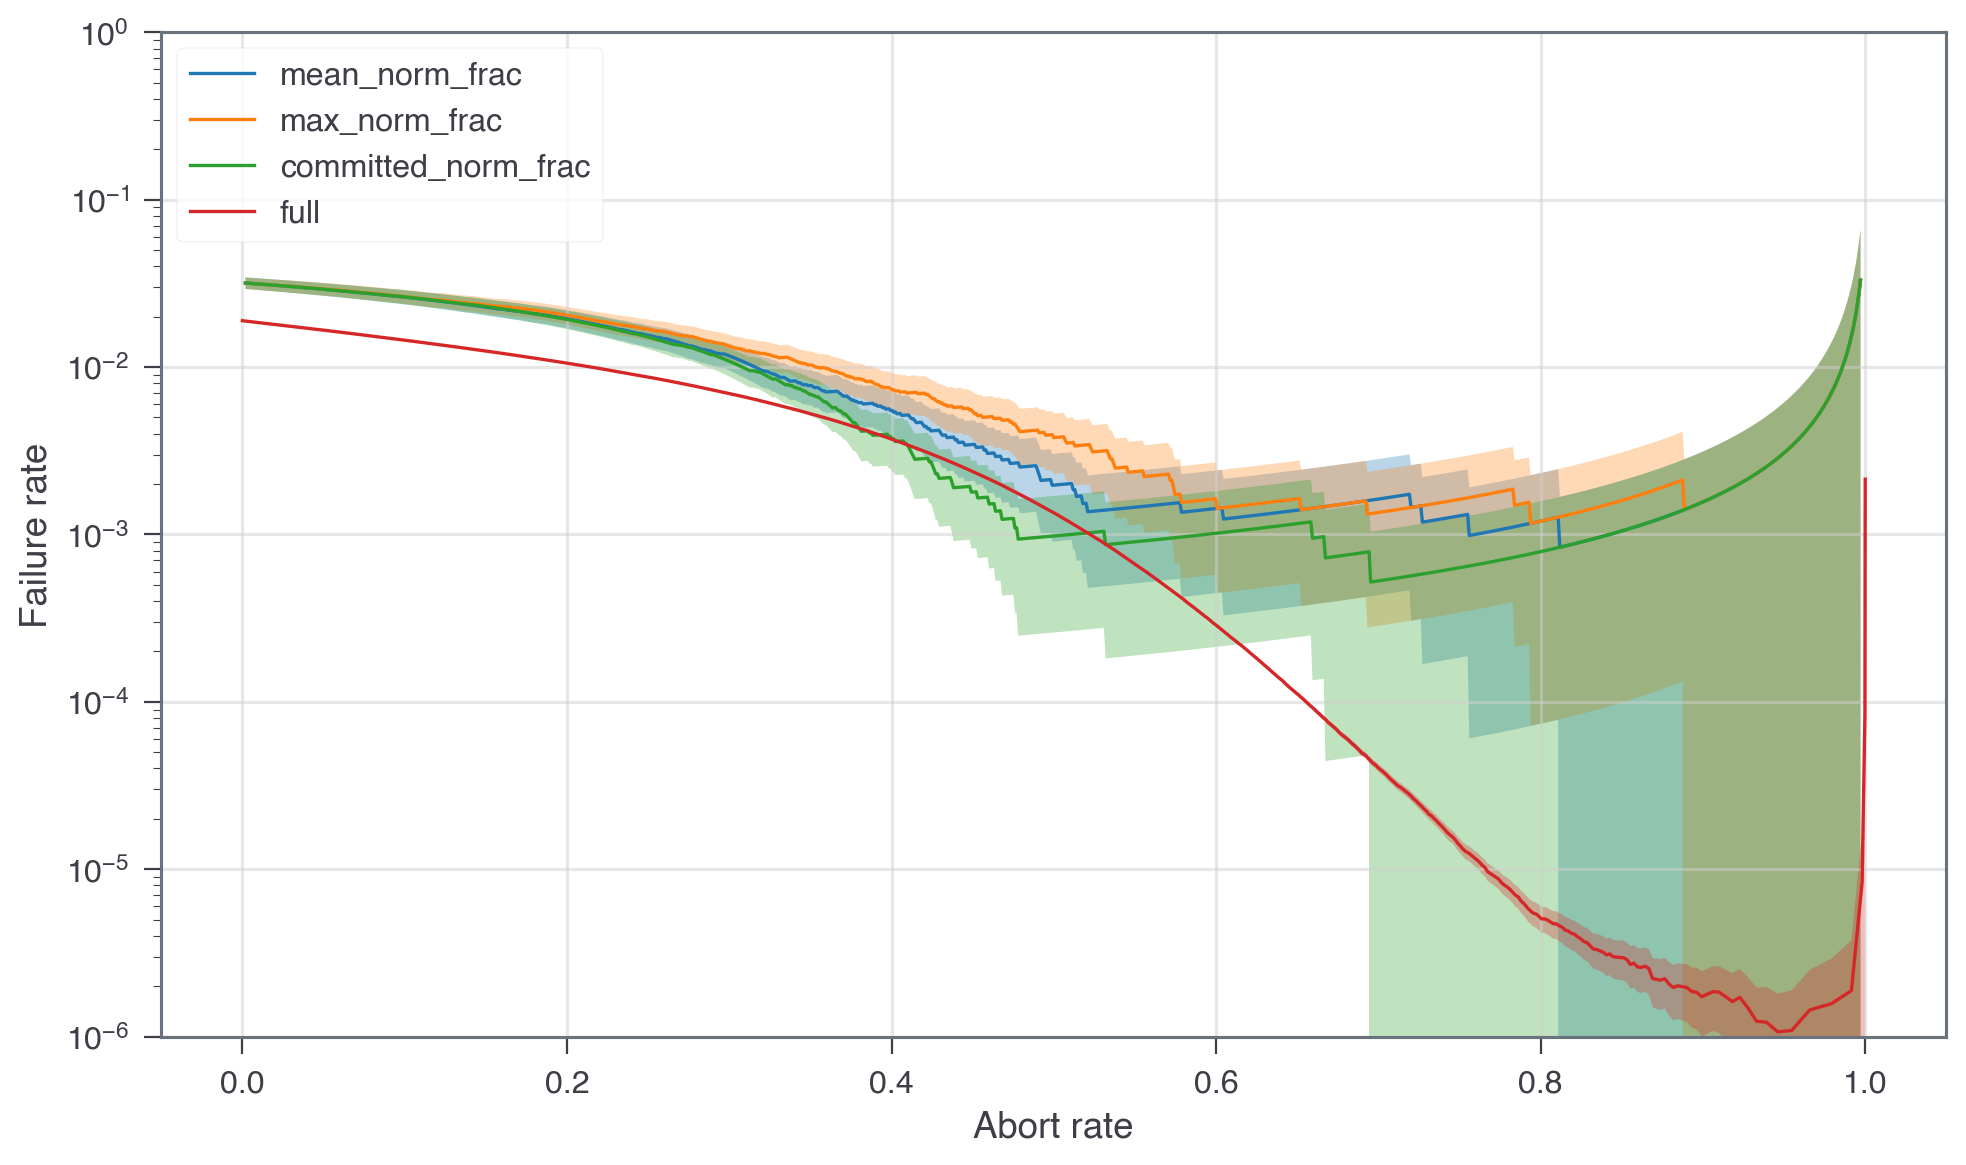

In [93]:
import matplotlib.pyplot as plt
from simulations.analysis.plotting_helpers import error_band_plot

df_ps_full_sng = df_ps_full.loc[(144, 12, 5e-3)]
fig, ax = plt.subplots(figsize=(10, 6))

for i, (key, df_ps) in enumerate(df_ps_dict.items()):
    error_band_plot(
        df_ps["p_abort"],
        df_ps["p_fail"] / 12,
        df_ps["delta_p_fail"] / 12,
        ax=ax,
        label=key,
    )

error_band_plot(
    df_ps_full_sng["p_abort"],
    df_ps_full_sng["p_fail"] / 12,
    df_ps_full_sng["delta_p_fail"] / 12,
    ax=ax,
    label="full",
)

ax.set_yscale("log")
ax.set_ylim(1e-6, 1)

ax.set_xlabel("Abort rate")
ax.set_ylabel("Failure rate")
ax.legend()
plt.tight_layout()

In [109]:
circuit = build_BB_circuit(n=144, T=12, p=5e-3)
decoder = SoftOutputsBpLsdDecoder(circuit=circuit)

fail, soft_outputs_sng = decoder.simulate_single(
    sliding_window=True,
    window_size=3,
    commit_size=1,
    verbose=False,
    seed=0,
    norm_frac_orders=[2],
)

In [114]:
soft_outputs_sng['cluster_llrs_norm_frac_2']

[0.04786243729646241,
 0.012429816286747343,
 0.0017721779736161914,
 0.022062223322931566,
 0.06779901730762432,
 0.06075119988414994,
 0.021520972710058008,
 0.0011758852035499679,
 0.01150389447038529,
 0.01858245388441755,
 0.002369530037479073]

In [103]:
fail2, soft_outputs_sng2 = decoder.simulate_single(
    sliding_window=True,
    window_size=3,
    commit_size=1,
    verbose=False,
    seed=3,
    _benchmarking=True,
)

[Benchmarking] Initialization: 0.000360s
[Benchmarking] Window 0 - Get window structure (cached): 0.000004s
[Benchmarking] Window 0 - Extract detector outcomes: 0.000052s
[Benchmarking] Window 0 - Find active faults: 0.000637s
[Benchmarking] Window 0 - Extract submatrices: 0.000367s
[Benchmarking] Window 0 - Get/create decoder (cached): 0.000162s
[Benchmarking] Window 0 - Decode: 0.005501s
[Benchmarking] Window 0 - Convert to full size: 0.000137s
[Benchmarking] Window 0 - Determine commits: 0.000811s
[Benchmarking] Window 0 - Update masks: 0.000805s
[Benchmarking] Window 0 - Update detectors/prediction: 0.000200s
[Benchmarking] Window 0 total: 0.008974s
[Benchmarking] Window 1 - Get window structure (cached): 0.000005s
[Benchmarking] Window 1 - Extract detector outcomes: 0.000016s
[Benchmarking] Window 1 - Find active faults: 0.000306s
[Benchmarking] Window 1 - Extract submatrices: 0.000347s
[Benchmarking] Window 1 - Get/create decoder (cached): 0.000189s
[Benchmarking] Window 1 - Deco